Using Fashion MNIST Dataset

Source: https://github.com/zalandoresearch/fashion-mnist

# Download the data


---



In [0]:
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
# !pip install idx2numpy

In [2]:
import gzip
import idx2numpy
import numpy as np

#open gzip archives, convert idx files directly to numpy arrays
images_archive = gzip.open('/content/train-images-idx3-ubyte.gz')
labels_archive = gzip.open('/content/train-labels-idx1-ubyte.gz')
test_img_archive = gzip.open('/content/t10k-images-idx3-ubyte.gz')
test_lbl_archive = gzip.open('/content/t10k-labels-idx1-ubyte.gz')

images = idx2numpy.convert_from_file(images_archive)
labels = idx2numpy.convert_from_file(labels_archive)
test_images = idx2numpy.convert_from_file(test_img_archive)
test_labels = idx2numpy.convert_from_file(test_lbl_archive)

images.shape, labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# Plot a few images from the dataset

---




In [0]:
cats = {0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'}

In [0]:
import matplotlib.pyplot as plt

def show_img(img, title=None, figsize=None, ax=None):
  if not ax: fig, ax = plt.subplots(figsize=figsize)
  if str(title): ax.set_title(title)
  ax.imshow(img, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  return ax

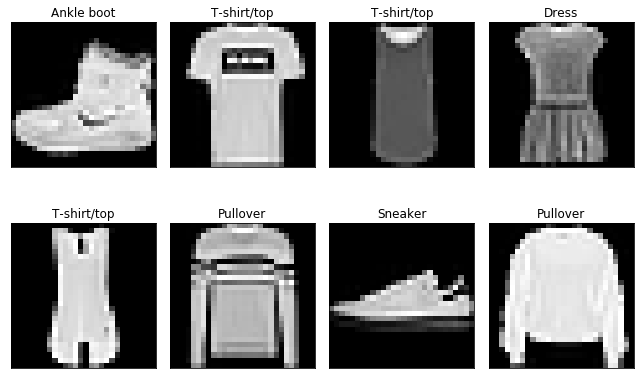

In [5]:
#from train dataset
fig, axes = plt.subplots(2, 4, figsize=(9,6))
for i, ax in enumerate(axes.flat):
  img = images[i]
  label = labels[i]
  ax = show_img(img, title=cats[label], ax=ax)
plt.tight_layout()

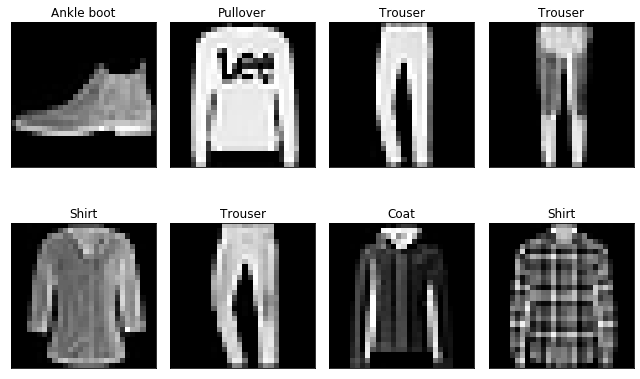

In [6]:
#from test dataset
fig, axes = plt.subplots(2, 4, figsize=(9,6))
for i, ax in enumerate(axes.flat):
  img = test_images[i]
  label = test_labels[i]
  ax = show_img(img, title=cats[label], ax=ax)
plt.tight_layout()

# Split training data to train/eval sets

---


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_eval, Y_train, Y_eval = train_test_split(images,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, Y_train.shape, X_eval.shape, Y_eval.shape

((48000, 28, 28), (48000,), (12000, 28, 28), (12000,))

# Image preprocessing

---



In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = 'cuda'

**Important!**

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

Source: https://pytorch.org/docs/stable/torchvision/models.html

Steps:

1. Convert grayscale to RGB-like 3-channel image
2. Resize to (224, 224)
3. Convert pixel values to a range of [0, 1]
4. Normalize the image




**Step 1**: Converting a grayscale image to RGB format by simply repeating color channel 3 times.

Sources:
1.   [I'm trying to use pre-trained model, but images are single channel](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63710)
2.   [Convert grayscale value to RGB representation?](https://stackoverflow.com/questions/835753/convert-grayscale-value-to-rgb-representation)
3.  [How can I use a pre-trained neural network with grayscale images?](https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images)


(28, 28)


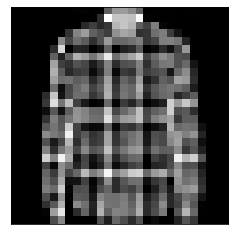

In [9]:
print(img.shape)
show_img(img);

(3, 28, 28)


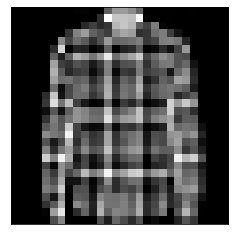

In [10]:
img_stacked = np.stack([img]*3, 0)
print(img_stacked.shape)
#swap axes from (3, 28, 28) to (28, 28, 3)
transposed = np.transpose(img_stacked, (1, 2, 0))
show_img(transposed);

The image hasn't changed, but now it has 3 channels.

Image stats before transformations:
Shape: (3, 28, 28)
Mean: 60.9260, std: 62.9352, min: 0, max: 255


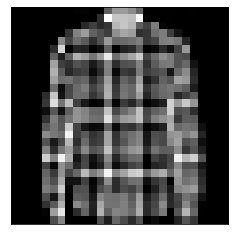

In [11]:
mean = np.mean(img_stacked)
std = np.std(img_stacked)
mn = np.min(img_stacked)
mx = np.max(img_stacked)
print('Image stats before transformations:')
print('Shape:', img_stacked.shape)
print(f'Mean: {mean:.4f}, std: {std:.4f}, min: {mn}, max: {mx}')
transposed = np.transpose(img_stacked, (1, 2, 0))
show_img(transposed);

**Steps 2-4**: converting image to tensor, resizing, normalizing



We can use built-in `torchvision.transforms` to simplify the process. It's using `PIL image` as input and outputs a pytorch tensor, ready to be passed into a neural network.

Sources:

1.   [How to do single image normalization](https://forums.fast.ai/t/nearly-solved-how-to-do-single-image-normalization/45694)
2.   [How to convert Numpy array to PIL image](https://stackoverflow.com/questions/10965417/how-to-convert-numpy-array-to-pil-image-applying-matplotlib-colormap)
3. [How to normalize a tensor to 0 mean and 1 variance?](https://discuss.pytorch.org/t/how-to-normalize-a-tensor-to-0-mean-and-1-variance/18766/6)

In [0]:
from PIL import Image

In [0]:
tfms = torchvision.transforms.Compose([
torchvision.transforms.Resize(224),                           #step 2 - resize
torchvision.transforms.ToTensor(),                            #step 3 - [0, 1]
torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],  #step 4 - normalize
                     std=[0.229, 0.224, 0.225])
])

In [0]:
#Image.fromarray() expects array to be in format (Height, Width, Channels)
new_img = Image.fromarray(np.transpose(img_stacked, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After transformations:
Shape: torch.Size([3, 224, 224])
Mean: -0.9280, std: 0.9571, min: -2.1179, max: 2.3960


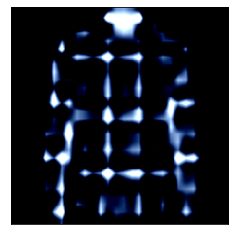

In [15]:
tensor = tfms(new_img)
mean = tensor.mean()
std = tensor.std()
mn = tensor.min()
mx = tensor.max()
print('After transformations:')
print('Shape:', tensor.shape)
print(f'Mean: {mean:.4f}, std: {std:.4f}, min: {mn:.4f}, max: {mx:.4f}')
transformed = tensor.cpu().detach().numpy()
transposed = np.transpose(transformed, (1, 2, 0))
show_img(transposed);

This values seem strange. I was expecting min to be 0, max to be 1, mean and std be ~0.485 and ~0.225 accordingly.

Let's explore [official documentation](https://pytorch.org/hub/pytorch_vision_resnet/) and look for an example.

In [0]:
#download an image from COCO dataset http://cocodataset.org/
#!wget http://farm4.staticflickr.com/3313/3408137435_46bdc105c4_z.jpg

In [0]:
filename = '/content/3408137435_46bdc105c4_z.jpg'

In [0]:
# copypasted from https://pytorch.org/hub/pytorch_vision_resnet/
from PIL import Image
import torchvision.transforms as tf
input_image = Image.open(filename)
preprocess = tf.Compose([
    tf.Resize(256),
    tf.CenterCrop(224),
    tf.ToTensor(),
    tf.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After transformations:
Shape: torch.Size([3, 224, 224])
Mean: 0.8576, std: 1.0338, min: -2.0494, max: 2.4483


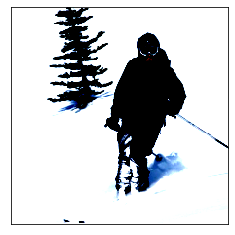

In [19]:
mean = input_tensor.mean()
std = input_tensor.std()
mn = input_tensor.min()
mx = input_tensor.max()
print('After transformations:')
print('Shape:', input_tensor.shape)
print(f'Mean: {mean:.4f}, std: {std:.4f}, min: {mn:.4f}, max: {mx:.4f}')
transformed = input_tensor.cpu().detach().numpy()
transposed = np.transpose(transformed, (1, 2, 0))
show_img(transposed);

Looks like our values are fine.

More info: [Normalize returning incorrect data](https://github.com/pytorch/vision/issues/642)

Proceed!

# Create custom Dataset class

---



In [0]:
class FashionDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    self.tfms = tf.Compose([tf.Resize(224),                           
                            tf.ToTensor(),                            
                            tf.Normalize(
                                mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
                            ])

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, i):
    x, y = self.X[i], self.Y[i]
    x = np.stack([x]*3, 0)
    x = Image.fromarray(np.transpose(x, (1, 2, 0)))
    x = self.tfms(x).to(device)
    y = torch.LongTensor([y]).to(device)
    return (x, y)

In [21]:
train_ds = FashionDataset(X_train, Y_train)
eval_ds = FashionDataset(X_eval, Y_eval)
test_ds = FashionDataset(test_images, test_labels)

#Length in number of images
len(train_ds), len(eval_ds), len(test_ds)

(48000, 12000, 10000)

In [22]:
x, y = train_ds[0]
print(x.mean(), x.std(), x.min(), x.max())
print(x.shape, y.shape)

tensor(-1.1685, device='cuda:0') tensor(1.4590, device='cuda:0') tensor(-2.1179, device='cuda:0') tensor(2.6226, device='cuda:0')
torch.Size([3, 224, 224]) torch.Size([1])


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

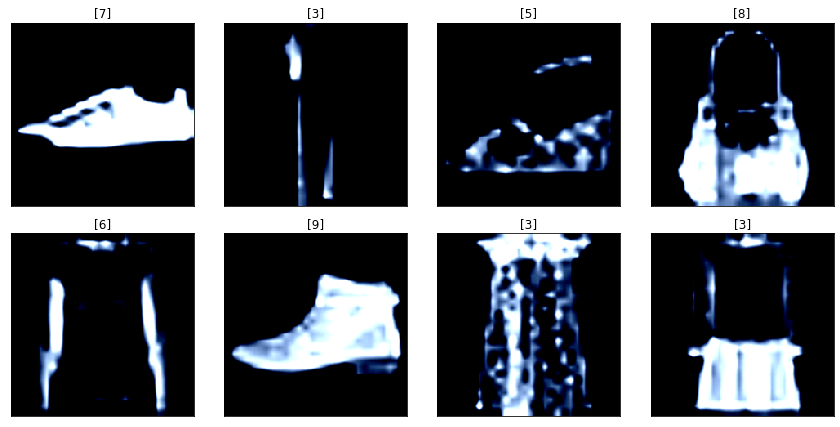

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(12,6))
for i, ax in enumerate(axes.flat):
  x, y = train_ds[i]
  x = x.cpu().detach().numpy()
  y = y.cpu().detach().numpy()
  ax = show_img(np.transpose(x, (1, 2, 0)), title=y, ax=ax)
plt.tight_layout()

In [24]:
bs = 64

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=bs, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True)

#Length in number of batches
len(train_dl), len(eval_dl), len(test_dl)

(750, 188, 157)

# Neural network


---



Load pretrained network, freeze all parameters and add custom head

In [25]:
model = torchvision.models.resnet34(pretrained=True)
for param in model.parameters():
  param.requires_grad = False

model.fc = torch.nn.Linear(512, 10, bias=True)
model.to(device)

from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Sanity check. Passing data through the network, confirming that it works and output shape is the same as we expected it to be.

In [26]:
x, y = train_ds[0]
pred = model(x[None])
print(pred, pred.shape)

tensor([[-0.2090, -0.3029, -0.4028, -0.0756,  0.3458,  0.2581, -0.6067, -0.2740,
         -0.3347,  0.4011]], device='cuda:0', grad_fn=<AddmmBackward>) torch.Size([1, 10])


# Train the model

---



In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

**overfit one batch** - one of the best advices I've heard about training neural networks.
[A Recipe for Training Neural Networks](http://karpathy.github.io/2019/04/25/recipe/)

In [0]:
def overfit(model, iterations, lr):
  optimizer.param_groups[0]['lr'] = lr
  x, y = train_ds[0]
  x = x[None]
  model.train()
  for i in range(iterations):
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    print(f'\rLoss: {loss.item():.4f}; prediction: {int(torch.argmax(pred, -1))}, truth: {int(y)}; iteration: {i+1}/{iterations}', end='')

In [29]:
overfit(model, iterations=100, lr=1e-4)

Loss: 0.0555; prediction: 7, truth: 7; iteration: 100/100

In [0]:
def train_model(model, n_epochs, lr, bs=bs):
  optimizer.param_groups[0]['lr'] = lr

  train_batches = len(train_dl)
  len_train = train_batches*bs
  val_batches = len(eval_dl)
  len_val = val_batches*bs

  for epoch in range(n_epochs):
    print(f'Epoch: {epoch+1}/{n_epochs}')

    #train loop
    model.train()
    train_loss = 0
    train_acc = 0
    for i, (x, y) in enumerate(train_dl, 1):
      y = y.squeeze(1)
      optimizer.zero_grad()
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      batch_acc = (torch.argmax(pred, -1)==y).sum().float()/y.shape[0]
      train_acc += batch_acc
      print(f'\rTrain loss: {train_loss/i:.4f}; train acc: {train_acc/i:.4f}; batch: {i}/{train_batches}', end='')

    #eval loop
    print('')
    model.eval()
    val_loss = 0
    val_acc = 0
    for i, (x, y) in enumerate(eval_dl, 1):
      y = y.squeeze(1)
      pred = model(x)
      loss = criterion(pred, y)
      val_loss += loss.item()
      batch_acc = (torch.argmax(pred, -1)==y).sum().float()/y.shape[0]
      val_acc += batch_acc
      print(f'\rVal loss: {val_loss/i:.4f}; val acc: {val_acc/i:.4f}; batch: {i}/{val_batches}', end='')
    print('\n')

In [31]:
train_model(model, n_epochs=3, lr=1e-3)

Epoch: 1/3
Train loss: 0.6941; train acc: 0.7791; batch: 750/750
Val loss: 0.4785; val acc: 0.8303; batch: 188/188

Epoch: 2/3
Train loss: 0.4608; train acc: 0.8391; batch: 750/750
Val loss: 0.4472; val acc: 0.8407; batch: 188/188

Epoch: 3/3
Train loss: 0.4277; train acc: 0.8478; batch: 750/750
Val loss: 0.4194; val acc: 0.8489; batch: 188/188



In [0]:
for param in model.parameters():
  param.requires_grad = True

In [33]:
train_model(model, n_epochs=1, lr=1e-3)

Epoch: 1/1
Train loss: 0.3452; train acc: 0.8773; batch: 750/750
Val loss: 0.2605; val acc: 0.9067; batch: 188/188



In [34]:
train_model(model, n_epochs=1, lr=1e-4)

Epoch: 1/1
Train loss: 0.1696; train acc: 0.9397; batch: 750/750
Val loss: 0.1714; val acc: 0.9357; batch: 188/188



In [35]:
train_model(model, n_epochs=1, lr=1e-5)

Epoch: 1/1
Train loss: 0.1336; train acc: 0.9525; batch: 750/750
Val loss: 0.1633; val acc: 0.9400; batch: 188/188



# Validate the model

---



In [0]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, f1_score

In [0]:
def test_model(model):
  
  model.eval()
  test_acc = 0
  len_test = len(test_dl)
  preds = torch.Tensor(0).to(device)
  Ys = torch.LongTensor(0).to(device)
  for i, (x, y) in enumerate(test_dl, 1):
    y = y.squeeze(1)
    pred = model(x)
    preds = torch.cat((preds, torch.argmax(pred, -1).float()))
    Ys = torch.cat((Ys, y))
    print(f'\rProcessing batch {i}/{len_test}', end='')

  test_acc = (preds==Ys).sum().float()/len(test_dl.dataset)
  print(f'\rTest accuracy: {test_acc:.4f}')
  f1 = f1_score(preds.cpu(), Ys.cpu(), average='macro')
  print(f'F1 score: {f1:.4f}')

  cm = confusion_matrix(preds.cpu(),Ys.cpu())
  plt.figure(figsize=(12,9))
  sn.heatmap(cm, annot=True, fmt='d')

Test accuracy: 0.9389
F1 score: 0.9387


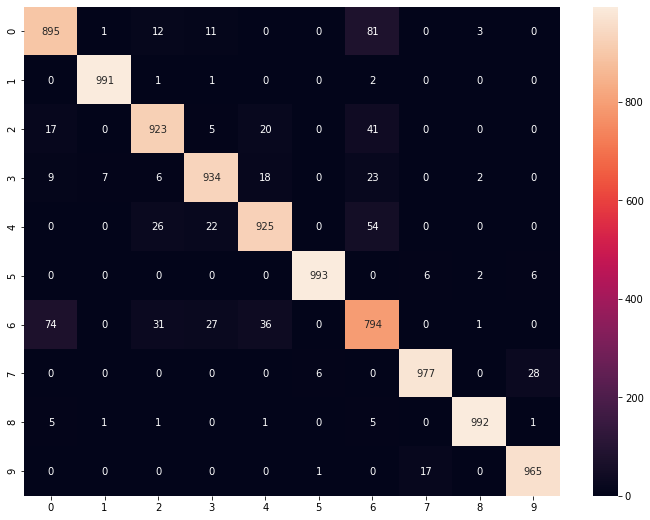

In [40]:
test_model(model)